# Explore the Data

First I downloaded the training data

In [102]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

In [45]:
df_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10
...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,MORTGAGE,8.0,EDUCATION,A,3000,7.29,0,0.02,N,17
26060,23,48000,RENT,1.0,VENTURE,A,4325,5.42,0,0.09,N,4
26061,22,60000,RENT,0.0,MEDICAL,B,15000,11.71,0,0.25,N,4
26062,30,144000,MORTGAGE,12.0,PERSONAL,C,35000,12.68,0,0.24,N,8


In [17]:
table = df_train.groupby(['loan_status']).aggregate({'person_age': 'mean', 'person_emp_length': 'mean'})
print(table)

             person_age  person_emp_length
loan_status                               
0             27.816506           4.954096
1             27.439076           4.159375


We see here mean age and employment rate for each loan status. This table shows us that there is not significant variation on loan status based on age or employment length. This is an important finding as it indicates that these two features are probably not the most useful indicators of loan status.

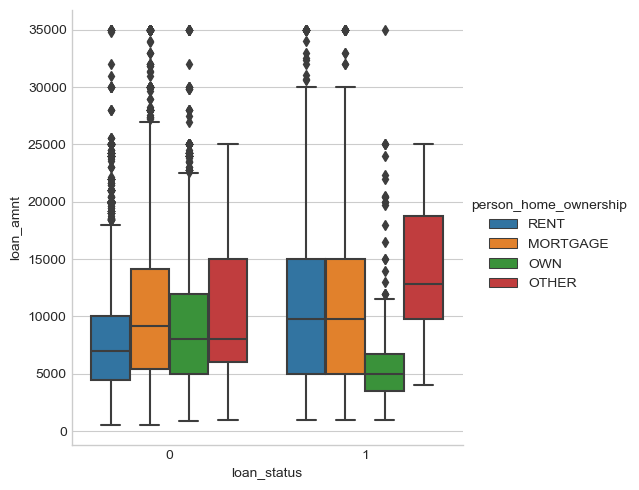

In [18]:
import seaborn as sns

sns.catplot(data=df_train, x="loan_status", y="loan_amnt", hue="person_home_ownership", kind="box")

Here we see loan status graphed against loan amount, with a color/bar separation based on home ownership type: rent, mortgage, own, or other. This graph shows us a couple of things. Firstly, that defaulted loans are on average of a higher loan amount. This is clearest when you compare each home ownership category loan status rate/ loan amount. It also shows a general trend of the other category and mortgage having teh highest loan amounts while rent and own and slightly lower.

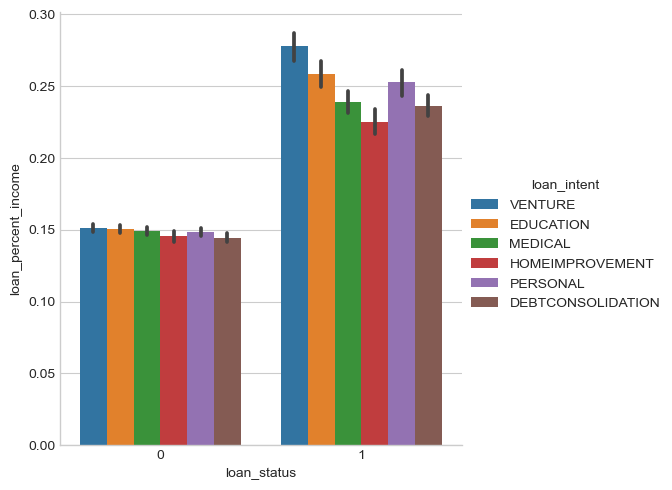

In [19]:
sns.catplot(data=df_train, x="loan_status", y="loan_percent_income", hue="loan_intent", kind="bar")

This figure shows loan status graphed against loan percent income. The color of each bar indicates the loan intent: venture, education, medical, home improvement, personal, or debt consolidation. This graph shows a stark disparity in loan percent income for loan status, with defaulted loans having overall significantly higher loan percentage incomes. The difference in loan percent income on loan intent categories is almost negligible for repaid loans and becomes more significant in defaulted loans (in the order venture, medical, personal, medical and debt consolidation, then home improvement).

# Train Logistic Regression 

First, I prepared the data by dropping loan grate and status on the training set and dropping na columns and fitting qualitative columns.

In [103]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_train["loan_status"])

def prepare_data(df_train):
  df_train = df_train.drop(["loan_grade"], axis = 1)
  df_train = df_train.dropna()
  df_train["cb_person_default_on_file"] = le.fit_transform(df_train["cb_person_default_on_file"])
  df_train["loan_intent"] = le.fit_transform(df_train["loan_intent"])  
  df_train = pd.get_dummies(df_train)
  return df_train

df_train = prepare_data(df_train)
y_train = df_train["loan_status"].to_numpy()
X_train = df_train.drop(["loan_status"], axis = 1)


In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
import pandas as pd 
from itertools import combinations

home_ownership_cols = [col for col in X_train.columns if 'person_home_ownership' in col]

bestLRScore = 0.0
bestLRCols=[]

for triple in combinations(X_train.columns, 3):

    cols = list(triple)
    
    if any( col in home_ownership_cols for col in cols):
        cols += home_ownership_cols
        
    LR = LogisticRegression()
    
    LRScore = cross_val_score(LR, X_train[cols], y_train, cv=5).mean()
    
    if LRScore >= bestLRScore :
      bestLRScore = LRScore
      bestLRCols = cols

print(bestLRScore)
print(bestLRCols)        
    
LR = LogisticRegression(random_state=0)
LR.fit(X_train[bestLRCols], y_train)
weights = LR.coef_

print(weights)

/Users/lindseyschweitzer/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lindseyschweitzer/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

0.8489539327556717
['person_age', 'loan_percent_income', 'person_home_ownership_MORTGAGE', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT']
[[-4.410e-03  8.254e+00 -2.684e-01 -2.684e-01  8.875e-02 -1.623e+00
   4.830e-01]]


/Users/lindseyschweitzer/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Graphs to see best threshold

In [105]:
import numpy as np


def linear_score(X, w):
    return X@w.T


s = linear_score(X_train[bestLRCols], weights)

ROC curve which shows the TPR and FPR for many different values of the threshold t. We want to find a point where TPR is maximized and FPR is minimized.

100%|██████████| 101/101 [00:00<00:00, 3517.83it/s]


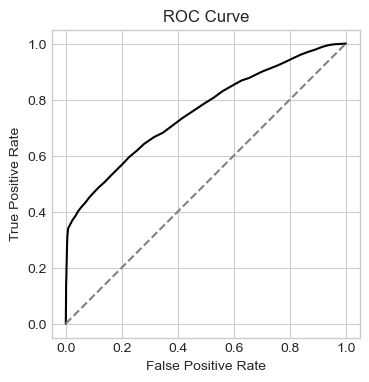

In [106]:
from matplotlib import pyplot as plt
import tqdm
np.set_printoptions(precision = 3)
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

num_thresholds = 101

FPR = np.zeros(num_thresholds)
TPR = np.zeros(num_thresholds)
T = np.linspace(s.min()-0.1, s.max()+0.1, num_thresholds)
s    = linear_score(X_train[bestLRCols], weights).to_numpy().reshape(-1)

for i in tqdm.trange(num_thresholds):
    t = T[i]
    preds    = s >= t
    FPR[i]   = ((preds== 1) * (y_train == 0)).sum() / (y_train == 0).sum()
    TPR[i]   = ((preds== 1) * (y_train == 1)).sum() / (y_train == 1).sum()


ax.plot(FPR, TPR, color = "black")
ax.plot([0,1], [0,1], linestyle="--", color = "grey")
ax.set_aspect('equal')

labs = ax.set(xlabel = "False Positive Rate", ylabel = "True Positive Rate", title = "ROC Curve")

The loan cost depends on the loan amount  and the loan interest rate. The gain cost, or the cost of a true negative (negative meaning not defaulting on a loan) can be calculated as ..... and the loss cost, or the cost of a false negative (bank giving someone a loan who defualts) can be calculated as.....

In [107]:
def create_cost_cols(df):
    df["gain_if_repaid"] = df["loan_amnt"]*(1 + 0.25*(df["loan_int_rate"]/100))**10 - df["loan_amnt"]
    df["cost_if_default"] = df["loan_amnt"]*(1 + 0.25*(df["loan_int_rate"]/100))**3 - 1.7*df["loan_amnt"]
    return df
    

s=array([1.3544937121706375, 2.6146963999365647, 0.7899173781100635, ...,
       2.4496091565965483, 1.3119312312494686, 3.344359977337155],
      dtype=object)


  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:00<00:00, 2603.43it/s]


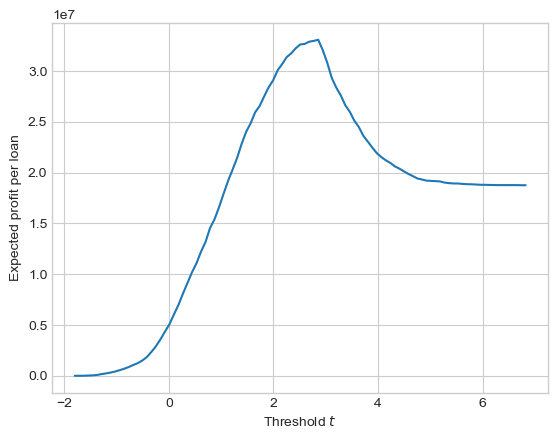

In [108]:
from matplotlib import pyplot as plt
np.set_printoptions(precision = 3)
import tqdm

num_thresholds = 101

gains = np.zeros(num_thresholds)

T = np.linspace(s.min()-0.1, s.max()+0.1, num_thresholds)
s    = linear_score(X_train[bestLRCols], weights).to_numpy().reshape(-1)
X_train["s"] = s

print(f"{s=}")

gain_of_TN = 0
cost_of_FN = 0

create_cost_cols(df_train)

for i in tqdm.trange(num_thresholds):
    t = T[i]
    preds    = s >= t
    
    gain_of_TN = (((preds == 0) * (y_train == 0)) * df_train["gain_if_repaid"]).sum()
     
    cost_of_FN = (((preds == 0) * (y_train == 1)) * df_train["cost_if_default"]).sum()
    # print(f"{cost_of_FN=}")
    gains[i] =  gain_of_TN + cost_of_FN

plt.plot(T, gains)
# plt.gca().set(ylim = (0, 3.0), xlim = (0, 1.0))
labs = plt.gca().set(xlabel = r"Threshold $t$", ylabel = "Expected profit per loan")

In [109]:

# calculate gain per loan (sum per each (defult or not) and then divide by total loan)
mean_gain_of_TN = (((preds == 0) * (y_train == 0)) * df_train["gain_if_repaid"]).mean()
mean_cost_of_FN = (((preds == 0) * (y_train == 1))* df_train["cost_if_default"]).mean()

gain_per_loan = mean_gain_of_TN + mean_cost_of_FN

In [110]:
gain_per_loan

818.6902697103415

In [111]:
max_y = np.argmax(gains)
t = T[max_y]
print(t)

2.857653939857805


In [91]:
t

6.824238793264327

# TESTING

In [112]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

df_test = prepare_data(df_test)
y_test = df_test["loan_status"].to_numpy()
X_test = df_test.drop(["loan_status"], axis = 1)

In [113]:
s    = linear_score(X_test[bestLRCols], weights).to_numpy().reshape(-1)
preds = s >= t

X_test["s"] = s
create_cost_cols(df_test)

gain_of_TN = ((((preds == 0) * (y_test == 0))) * df_test["gain_if_repaid"]).sum()
cost_of_FN =( (((preds == 0) * (y_test == 1))) * df_test["cost_if_default"]).sum()

# compute the expected gain
gain = gain_of_TN + cost_of_FN
gain

7931919.35735091

In [99]:
preds.mean() # so giving loans to most people

0.08584889199092655

In [114]:

# calculate gain per loan (sum per each (defult or not) and then divide by total loan)
mean_gain_of_TN_test = (((preds == 0) * (y_test == 0)) * df_test["gain_if_repaid"]).mean()
mean_cost_of_FN_test = (((preds == 0) * (y_test == 1))* df_test["cost_if_default"]).mean()

gain_per_loan_test = mean_gain_of_TN_test + mean_cost_of_FN_test

In [115]:
gain_per_loan_test

1384.0375776218652

# Evaluate Model

In [ ]:
hist = plt.hist(s)

Part F: Evaluate Your Model From the Borrower’s Perspective
Now evaluate your model from the (aggregate) perspective of the prospective borrowers. Please quantitatively address the following questions, using the predictions of your model on the test data:

Is it more difficult for people in certain age groups to access credit under your proposed system?
Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that group? What about people seeking loans for business ventures or education?
How does a person’s income level impact the ease with which they can access credit under your decision system?

first put predicted_loan_status into a column

In [75]:
df_test["predicted_loan_status"] = preds
print(preds.all() == False)
print(df_test)

True
      person_age  person_income  person_emp_length  loan_intent  loan_amnt  \
0             21          42000                5.0            5       1000   
1             32          51000                2.0            0      15000   
2             35          54084                2.0            0       3000   
3             28          66300               11.0            3      12000   
4             22          70550                0.0            3       7000   
...          ...            ...                ...          ...        ...   
6511          29          78000                2.0            4      18000   
6513          27          44640                0.0            3      12800   
6514          24          48000                5.0            5      10400   
6515          26          65000                6.0            1       6000   
6516          29          61000               12.0            5      10000   

      loan_int_rate  loan_status  loan_percent_income  \
0

In [76]:
df_test.groupby("person_age")[["loan_status", "predicted_loan_status"]].mean()


,loan_status,predicted_loan_status
person_age,,
20,0.000000,0.000000
21,0.325581,0.139535
22,0.229921,0.110236
23,0.225627,0.104457
24,0.200000,0.071545
25,0.239089,0.083491
26,0.196035,0.068282
27,0.216138,0.095101
28,0.259701,0.101493


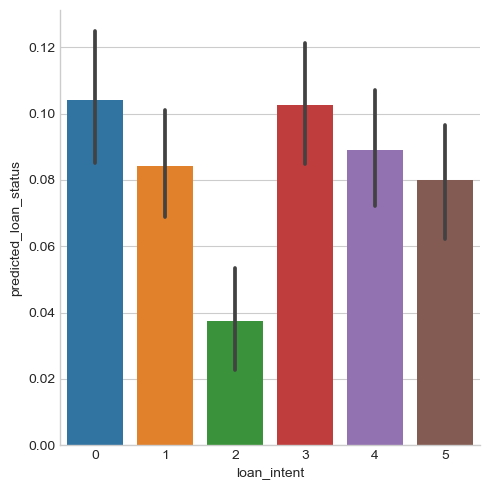

In [68]:
import seaborn as sns
sns.catplot(data=df_test, kind="bar", x="loan_intent", y="predicted_loan_status")


